In [38]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [9]:
donations = pd.read_csv('https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/donations.csv', parse_dates=['timestamp'])
donations.head(3)

,amount,timestamp,user
0,25.0,2017-11-12 11:13:44,0.0
1,50.0,2015-08-25 19:01:45,0.0
2,25.0,2015-03-26 12:03:47,0.0


In [10]:
emails = pd.read_csv('https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/emails.csv', parse_dates=['week'])
emails.head(3)

,emailsOpened,user,week
0,3.0,1.0,2015-06-29
1,2.0,1.0,2015-07-13
2,2.0,1.0,2015-07-20


In [11]:
year_joined = pd.read_csv('https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/year_joined.csv', parse_dates=['yearJoined'])
year_joined.head(3)

,user,userStats,yearJoined
0,0,silver,2014-01-01
1,1,silver,2015-01-01
2,2,silver,2016-01-01


In [6]:
year_joined.groupby('user').count().groupby('userStats').count()

,yearJoined
userStats,
1,1000


### Verify & clean emailsOpened column

In [7]:
emails[emails.emailsOpened < 1]

,emailsOpened,user,week


There are two possibilities: either nulls are not reported or members always have at least one email event. Anyone who has worked with email data knows that it’s difficult to get people to open emails, so the hypothesis that members always open at least one email per week is quite unlikely. In this case, we can resolve this by looking at the history of just one user:

In [8]:
emails[emails.user == 998]

,emailsOpened,user,week
25464,1.0,998.0,2017-12-04 00:00:00
25465,3.0,998.0,2017-12-11 00:00:00
25466,3.0,998.0,2017-12-18 00:00:00
25467,3.0,998.0,2018-01-01 00:00:00
25468,3.0,998.0,2018-01-08 00:00:00
25469,2.0,998.0,2018-01-15 00:00:00
25470,3.0,998.0,2018-01-22 00:00:00
25471,2.0,998.0,2018-01-29 00:00:00
25472,3.0,998.0,2018-02-05 00:00:00
25473,3.0,998.0,2018-02-12 00:00:00


We can see that some weeks are missing. There aren’t any December 2017 email events after December 18, 2017.

We can check this more mathematically by calculating how many weekly observations we should have between the first and last event for that member. First we calculate the length of the member’s tenure, in weeks

In [13]:
# get the number of weeks the user opened the emails + 1
(max(emails[emails.user == 998].week) -
 min(emails[emails.user == 998].week)).days / 7

25.0

In [15]:
emails[emails.user == 998].shape

(24, 3)

Here we see 24 columns out of 26. There are non-recorded missing values

### Fill in the blanks

It’s a lot easier to fill in all missing weeks for all members by exploiting Pandas’ indexing functionality, rather than writing our own solution. We can generate a MultiIndex for a Pandas data frame, which will create all combinations of weeks and members—that is, a Cartesian product.

In [16]:
complete_idx = pd.MultiIndex.from_product(
    (set(emails.week), set(emails.user))
)

complete_idx

MultiIndex([('2018-04-09',   1.0),
            ('2018-04-09',   3.0),
            ('2018-04-09',   5.0),
            ('2018-04-09',   6.0),
            ('2018-04-09',   9.0),
            ('2018-04-09',  10.0),
            ('2018-04-09',  14.0),
            ('2018-04-09',  16.0),
            ('2018-04-09',  20.0),
            ('2018-04-09',  21.0),
            ...
            ('2015-12-21', 973.0),
            ('2015-12-21', 977.0),
            ('2015-12-21', 982.0),
            ('2015-12-21', 984.0),
            ('2015-12-21', 987.0),
            ('2015-12-21', 991.0),
            ('2015-12-21', 992.0),
            ('2015-12-21', 993.0),
            ('2015-12-21', 995.0),
            ('2015-12-21', 998.0)],
           length=93247)

We use this index to reindex the original table and fill in the missing values—in this case with 0 on the assumption that nothing recorded means there was nothing to record. We also reset the index to make the member and week information available as columns, and then name those columns:

In [26]:
all_email = emails.set_index(['week', 'user'])\
            .reindex(complete_idx, fill_value=0)\
            .reset_index()

all_email.columns = ['week', 'user', 'EmailsOpened']

In [28]:
all_email.head(3)

,week,user,EmailsOpened
0,2018-04-09,1.0,3.0
1,2018-04-09,3.0,1.0
2,2018-04-09,5.0,1.0


In [20]:
all_email[all_email.EmailsOpened == 0].count()

week            67759
member          67759
EmailsOpened    67759
dtype: int64

In [22]:
all_email['EmailsOpened'].value_counts(normalize=True)

0.0    0.726661
3.0    0.164617
1.0    0.054372
2.0    0.054350
Name: EmailsOpened, dtype: float64

Notice that we have a large number of zeros at the start. These are likely before the member joined the organization, so they would not have been on an email list. There are not too many kinds of analyses where we’d want to keep the member’s truly null weeks around—specifically those weeks before the member ever indicated opening an email. If we had the precise date a member started receiving emails, we would have an objective cutoff. As it is, we will let the data guide us. For each member we determine the start_date and end_date cutoffs by grouping the email DataFrame per member and selecting the maximum and minimum week values:

In [23]:
cutoff_dates = emails.groupby('user').week.agg(['min', 'max']).reset_index()
cutoff_dates

,user,min,max
0,1.0,2015-06-29,2018-05-28
1,3.0,2018-03-05,2018-04-23
2,5.0,2017-06-05,2018-05-28
3,6.0,2016-12-05,2018-05-28
4,9.0,2016-07-18,2018-05-28
...,...,...,...
534,991.0,2016-10-24,2016-10-24
535,992.0,2015-02-09,2015-07-06
536,993.0,2017-09-11,2018-05-28
537,995.0,2016-09-05,2018-05-28


In [29]:
for _, row in cutoff_dates.iterrows():
    user       = row['user']
    start_date = row['min']
    end_date   = row['max']

    all_email.drop(
        all_email[all_email.user == user][
            all_email.week < start_date
        ].index, inplace=True
    )

    all_email.drop(
        all_email[all_email.user == user][
            all_email.week > end_date
        ].index, inplace=True
    )

C:\Users\dinar\AppData\Local\Temp\ipykernel_8492\3377467453.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_email[all_email.user == user][
C:\Users\dinar\AppData\Local\Temp\ipykernel_8492\3377467453.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_email[all_email.user == user][


In [30]:
all_email.EmailsOpened.value_counts()

3.0    15350
0.0     6348
1.0     5070
2.0     5068
Name: EmailsOpened, dtype: int64

In [32]:
donations.set_index('timestamp', inplace=True)
donations.head(3)

,amount,user
timestamp,,
2017-11-12 11:13:44,25.0,0.0
2015-08-25 19:01:45,50.0,0.0
2015-03-26 12:03:47,25.0,0.0


In [33]:
agg_don = donations.groupby('user').apply(
          lambda x: x.amount.resample('W-MON').sum().dropna()
)

agg_don

user   timestamp 
0.0    2015-03-30      25.0
       2015-04-06       0.0
       2015-04-13       0.0
       2015-04-20       0.0
       2015-04-27       0.0
                      ...  
995.0  2017-09-11       0.0
       2017-09-18       0.0
       2017-09-25       0.0
       2017-10-02    1000.0
998.0  2018-01-08      50.0
Name: amount, Length: 32352, dtype: float64

<AxesSubplot:xlabel='timestamp'>

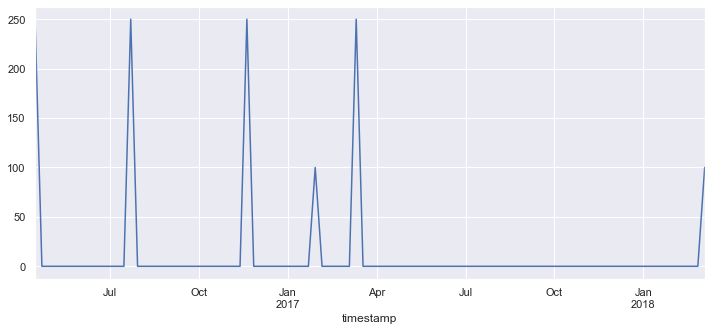

In [48]:
id_zero = agg_don.loc[796.0]

plt.figure(figsize=(12, 5))
id_zero.plot(x='timestamp', y='amount')
